<a href="https://colab.research.google.com/github/Hoang2531992/Unlearning_HoangTN/blob/main/HoangTN_of_Q1_Unlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar-10


## Download Pre-train model and Dataset

In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import functional as F

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [2]:
#Hyparameters
batch_size = 256

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=True, num_workers=2, generator=RNG
)

100%|██████████| 170498071/170498071 [00:03<00:00, 48913656.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(f"Train set size: {len(train_set)}")
print(f"Forget set size: {len(forget_set)}")
print(f"Retain set size: {len(retain_set)}")
print(f"Test set size: {len(test_set)}")
print(f"Val set size: {len(val_set)}")

Train set size: 50000
Forget set size: 5000
Retain set size: 45000
Test set size: 5000
Val set size: 5000


In [5]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

Files already downloaded and verified


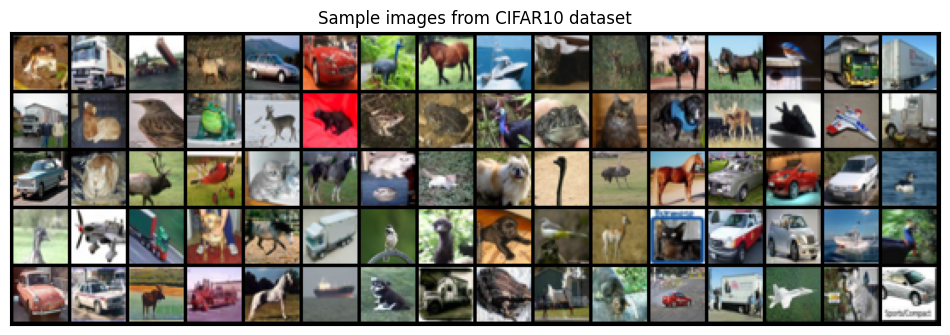

In [6]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

In [7]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [8]:
print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train set accuracy: 99.5%
Retain set accuracy: 99.5%
Forget set accuracy: 99.3%
Test set accuracy: 88.3%


### MIA

In [9]:
class cal_MIA:
  def __init__(self, DEVICE):
    self.DEVICE = DEVICE
  def compute_losses(self, net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(self.DEVICE), targets.to(self.DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


  def simple_mia(self, sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()  # attack_model just is the logistic Regresstion model
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )
  def MIA(self, model, A_loader, B_loader):
    A_losses = self.compute_losses(model, A_loader)
    B_losses = self.compute_losses(model, B_loader)

    # make sure we have a balanced dataset for the MIA
    if len(A_losses) > len(B_losses):
      np.random.shuffle(A_losses)
      A_losses = A_losses[: len(B_losses)]
    elif len(A_losses) < len(B_losses):
      np.random.shuffle(B_losses)
      B_losses = B_losses[: len(A_losses)]

    ft_samples_mia = np.concatenate((A_losses, B_losses)).reshape((-1, 1))
    labels_mia = [0] * len(A_losses) + [1] * len(B_losses)

    ft_mia_scores = self.simple_mia(ft_samples_mia, labels_mia)
    return ft_mia_scores.mean()

In [10]:
test = cal_MIA(DEVICE=DEVICE)
train_losses = test.compute_losses(model, train_loader)
test_losses = test.compute_losses(model, test_loader)

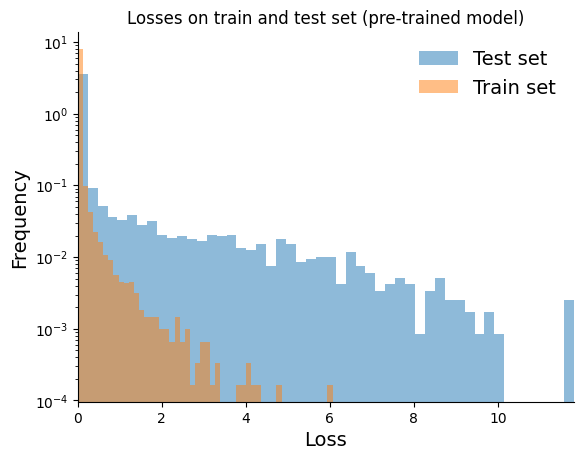

In [11]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [12]:
forget_losses = test.compute_losses(model, forget_loader)
retain_losses = test.compute_losses(model, retain_loader)

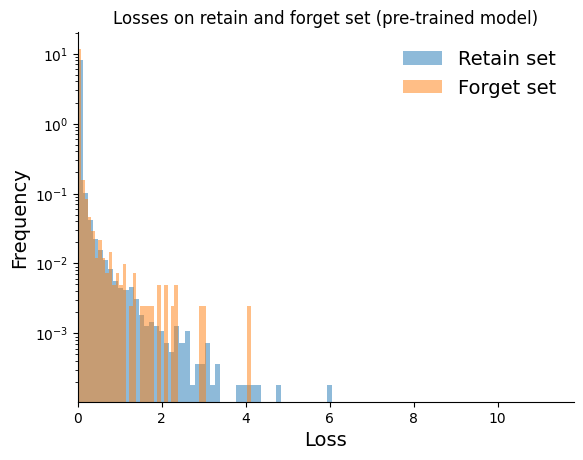

In [13]:
# plot losses on train and test set
plt.title("Losses on retain and forget set (pre-trained model)")
plt.hist(retain_losses, density=True, alpha=0.5, bins=50, label="Retain set")
plt.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [14]:
def plot(A_losses, B_losses, first_title, first_losses_label, second_losses_label, C_losses = None, D_losses = None,
         second_title = None):
  """
  2 options: plot 1 charts or plot 2 charts

  A_losses and C_losses must have the similiar pattern.

  """
  if(C_losses.any() == None and D_losses.any() == None and second_title == None):
    fig, ax1 = plt.subplots(1,1)
  else:
    assert(C_losses.any() != None and D_losses.any() != None and second_title != None)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  ax1.set_title(first_title)
  ax1.hist(A_losses, density=True, alpha=0.5, bins=50, label=first_losses_label)
  ax1.hist(B_losses, density=True, alpha=0.5, bins=50, label=second_losses_label)
  ax1.set_xlabel("Loss")
  ax1.set_ylabel("Frequency")
  ax1.set_yscale("log")
  ax1.set_xlim((0, np.max(A_losses)))
  ax1.spines["top"].set_visible(False)
  ax1.spines["right"].set_visible(False)
  ax1.legend(frameon=False, fontsize=14)

  if(C_losses.any() != None and D_losses.any() != None and second_title != None):
    ax2.set_title(second_title)
    ax2.hist(C_losses, density=True, alpha=0.5, bins=50, label=first_losses_label)
    ax2.hist(D_losses, density=True, alpha=0.5, bins=50, label=second_losses_label)
    ax2.set_xlabel("Loss")
    ax2.set_ylabel("Frequency")
    ax2.set_yscale("log")
    ax2.set_xlim((0, np.max(C_losses)))
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.legend(frameon=False, fontsize=14)

  plt.show()


## Unlearning Algorithm

### Fine Tune

#### Unlearn

In [59]:
def finetune(
    net,
    retain_loader,
    forget_loader,
    val_loader):
    """Simple unlearning by finetuning."""
    epochs = 1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs)
    net.train()

    for ep in range(epochs):
        net.train()
        for sample in retain_loader:
            inputs = sample[0]
            targets = sample[1]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()

In [60]:
%%time
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

finetune(ft_model, retain_loader, forget_loader, val_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CPU times: user 5.03 s, sys: 368 ms, total: 5.4 s
Wall time: 15.2 s


#### Validation

In [61]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.1f}%")

Retain set accuracy: 99.8%
Test set accuracy: 88.0%
Forget set accuracy: 99.2%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


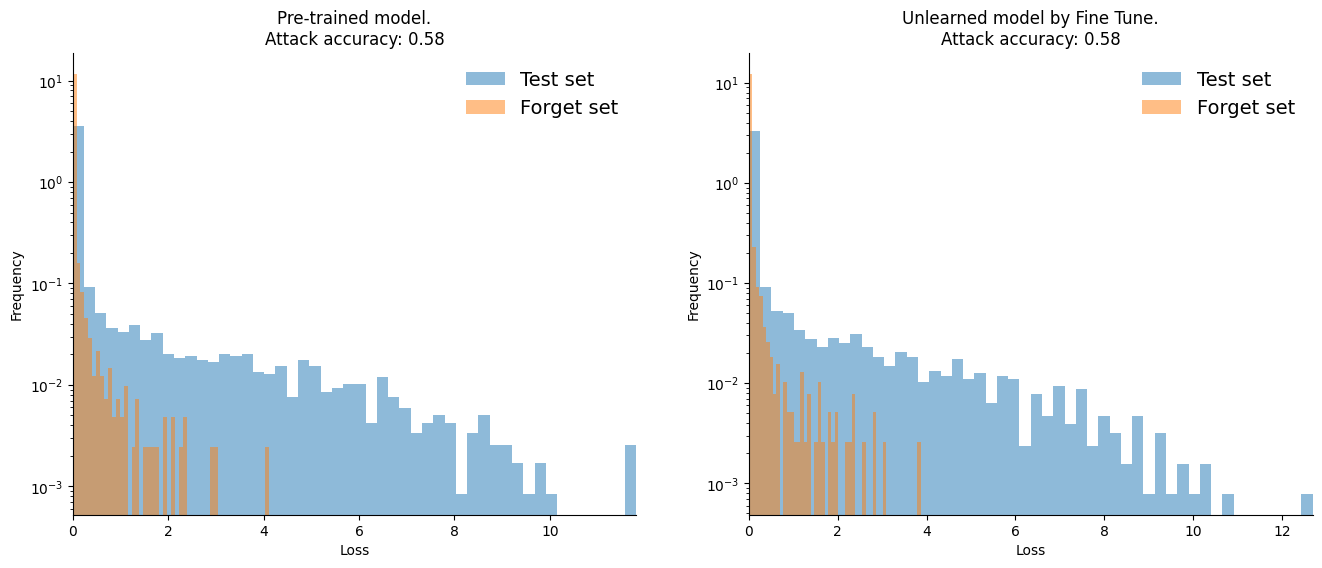

In [62]:
forget_losses = test.compute_losses(model, forget_loader)

ft_forget_losses = test.compute_losses(ft_model, forget_loader)
ft_test_losses = test.compute_losses(ft_model, test_loader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(model, test_loader, forget_loader):0.2f}", "Test set", "Forget set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Fine Tune.\nAttack accuracy: {test.MIA(ft_model, test_loader, forget_loader):0.2f}"
    )

### Amnesiac

In [19]:
import torch


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def training_step(model, batch, device):
    images, labels = batch
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    out = model(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    return loss



def validation_epoch_end(model, outputs):
    batch_losses = [x["Loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
    batch_accs = [x["Acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
    return {"Loss": epoch_loss.item(), "Acc": epoch_acc.item()}

@torch.no_grad()
# def evaluate(model, val_loader, device):
#     model.eval()
#     outputs = [validation_step(model, batch, device) for batch in val_loader]
#     return validation_epoch_end(model, outputs)

def epoch_end(model, epoch, result):
    print(
        "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,
            result["lrs"][-1],
            result["train_loss"],
            result["Loss"],
            result["Acc"],
        )
    )

def fit_one_unlearning_cycle(epochs, model, train_loader, lr, device):
    history = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch, device)
            loss.backward()
            train_losses.append(loss.detach().cpu())

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))

In [20]:
import random

def amnesiac(
    model,
    retain_train_dl,
    forget_train_dl,
    num_classes,
    device = DEVICE,
    **kwargs,
):
    unlearninglabels = list(range(num_classes))
    unlearning_trainset = []

    for x, label in forget_train_dl.dataset:
        rnd = random.choice(unlearninglabels)
        while rnd == label:
            rnd = random.choice(unlearninglabels)
        unlearning_trainset.append((x, rnd))

    for x, y in retain_train_dl.dataset:
        unlearning_trainset.append((x, y))

    unlearning_train_set_dl = DataLoader(
        unlearning_trainset, batch_size, pin_memory=True, shuffle=True
    )

    _ = fit_one_unlearning_cycle(
        4, model, unlearning_train_set_dl, device=device, lr=0.0001
    )

In [21]:
%%time
amnesiac_model = resnet18(weights=None, num_classes=10)
amnesiac_model.load_state_dict(weights_pretrained)
amnesiac_model.to(DEVICE)

amnesiac(amnesiac_model, retain_loader, forget_loader, 10)

CPU times: user 58.3 s, sys: 741 ms, total: 59.1 s
Wall time: 1min 1s


In [22]:
print(f"Retain set accuracy: {100.0 * accuracy(amnesiac_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(amnesiac_model, test_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(amnesiac_model, forget_loader):0.1f}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Retain set accuracy: 99.9%
Test set accuracy: 84.6%
Forget set accuracy: 59.0%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


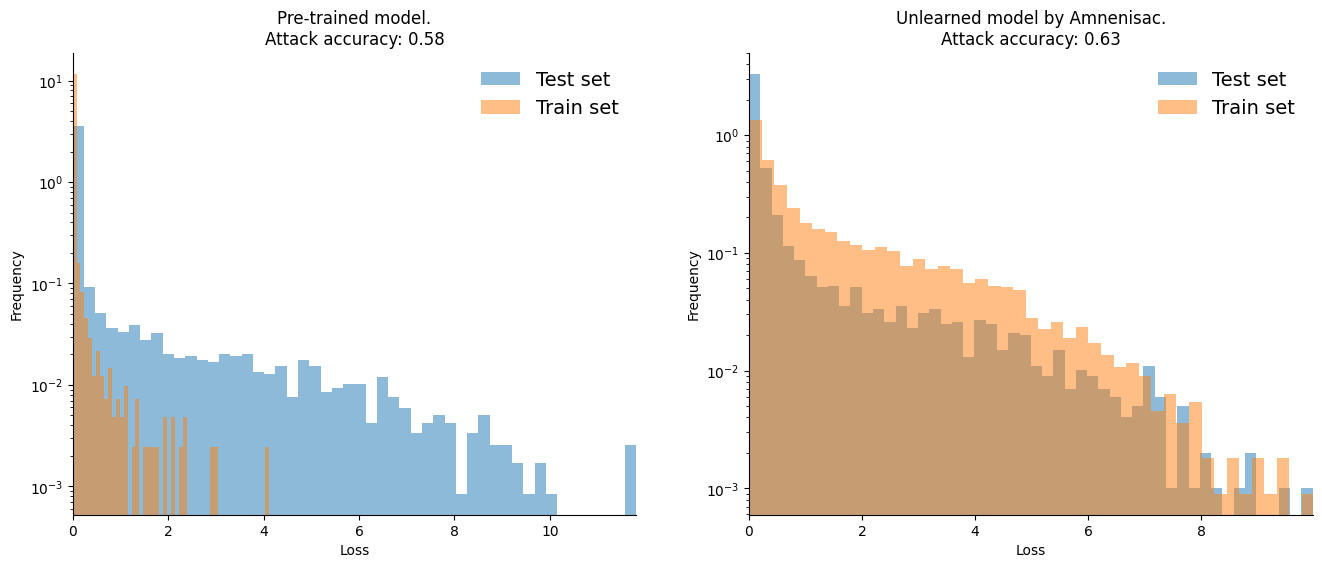

In [23]:
# forget_losses = test.compute_losses(model, forget_loader)

ft_forget_losses = test.compute_losses(amnesiac_model, forget_loader)
ft_test_losses = test.compute_losses(amnesiac_model, test_loader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(model, test_loader, forget_loader):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Amnenisac.\nAttack accuracy: {test.MIA(amnesiac_model, test_loader, forget_loader):0.2f}"
    )

### Scrub

#### Unlearn

In [24]:
class DistillKL(nn.Module):
    """Distilling the Knowledge in a Neural Network"""
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='batchmean') * (self.T**2) / y_s.shape[0]
        return loss

def sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate,  optimizer):
    """Sets the learning rate to the initial LR decayed by decay rate every steep step"""
    steps = np.sum(epoch > np.asarray(lr_decay_epochs))
    new_lr = sgda_learning_rate
    if steps > 0:
        new_lr = sgda_learning_rate * (lr_decay_rate ** steps)
    return new_lr

def train_distill(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):
#         if distill in ['crd']:  #opt - done
#             input, target, index, contrast_idx = data
#         else:
        input, target = data
        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
#             if distill in ['crd']:   #opt
#                 contrast_idx = contrast_idx.cuda()
#                 index = index.cuda()

        # ===================forward=====================
        #feat_s, logit_s = model_s(input, is_feat=True, preact=False)
        logit_s = model_s(input)
        with torch.no_grad():
            #feat_t, logit_t = model_t(input, is_feat=True, preact=preact)
            #feat_t = [f.detach() for f in feat_t]
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)

        # other kd beyond KL divergence
        loss_kd = 0


        if split == "minimize":
            loss = gamma * loss_cls + alpha * loss_div + beta * loss_kd #opt
        elif split == "maximize":
            loss = -loss_div

        loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        if split == "minimize" and not quiet:
            acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
        elif split == "maximize" and not quiet:
            kd_losses.update(loss.item(), input.size(0))
        elif split == "linear" and not quiet:
            acc1, _ = scrub_accuracy(logit_s, target, topk=(1, 1))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            kd_losses.update(loss.item(), input.size(0))


        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    if split == "minimize":
        return top1.avg, losses.avg
    else:
        return kd_losses.avg

def validate(val_loader, model, criterion):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = scrub_accuracy(output, target, topk=(1, 5)) ## Error
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

    return top1.avg, top5.avg, losses.avg

def scrub_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def param_dist(model, swa_model, p):
    #This is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    dist = 0.
    for p1, p2 in zip(model.parameters(), swa_model.parameters()):
        dist += torch.norm(p1 - p2, p='fro')
    return p * dist

In [25]:
import copy

def scrub(teacher, student, retain_loader, forget_loader):
    seed = 1
    opt = 'sgd'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 3
    clip = 0.2
    sstart = 10
    kd_T = 4
    lr = 0.01
    distill = 'kd'

    dataset = 'cifar10'
    model = 'resnet'

    sgda_epochs = 10
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    model_lst = []

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

#     forget_validation_loader = copy.deepcopy(validation_loader)

    ## Test
    # for i, j in forget_validation_loader:
    #   print(j)
    ##
    fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer) #Error

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        # acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        # acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= msteps:
            maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer,
                                          distill, gamma, alpha, beta, smoothing, "maximize")
        train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, "minimize",)
        if epoch >= sstart:
            swa_model.update_parameters(model_s)

        torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        # model_lst.append(model_s.state_dict())


        print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
    t2 = time.time()
    print (t2-t1)

    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    # selected_model = model_lst[selected_idx-1]
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(torch.load(selected_model))

    return model_s, model_s_final

In [26]:
!mkdir checkpoints

#### Evaluate

In [27]:
scrub_model = resnet18(weights=None, num_classes=10).to(DEVICE)
teacher = resnet18(weights=None, num_classes=10).to(DEVICE)

scrub_model.load_state_dict(weights_pretrained)
teacher.load_state_dict(weights_pretrained)

scrub_model.train()
teacher.eval()

scrub_current_model, scrub_final_model = scrub(teacher, scrub_model, retain_loader, forget_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


maximize loss: 0.00	 minimize loss: 0.08	 train_acc: 97.6866683959961
maximize loss: 0.01	 minimize loss: 0.08	 train_acc: 97.75555419921875
maximize loss: 0.01	 minimize loss: 0.09	 train_acc: 97.72000122070312
maximize loss: 0.00	 minimize loss: 0.08	 train_acc: 97.80667114257812
maximize loss: 0.00	 minimize loss: 0.09	 train_acc: 97.72444915771484
maximize loss: 0.00	 minimize loss: 0.08	 train_acc: 97.75333404541016
maximize loss: 0.00	 minimize loss: 0.09	 train_acc: 97.79777526855469
maximize loss: 0.00	 minimize loss: 0.09	 train_acc: 97.74666595458984
maximize loss: 0.00	 minimize loss: 0.08	 train_acc: 97.70000457763672
maximize loss: 0.00	 minimize loss: 0.08	 train_acc: 97.6977767944336
315.90543246269226
the selected index is 9


In [28]:
print(f"Retain set accuracy: {100.0 * accuracy(scrub_final_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(scrub_final_model, test_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(scrub_final_model, forget_loader):0.1f}%")

Retain set accuracy: 97.8%
Test set accuracy: 86.4%
Forget set accuracy: 97.8%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


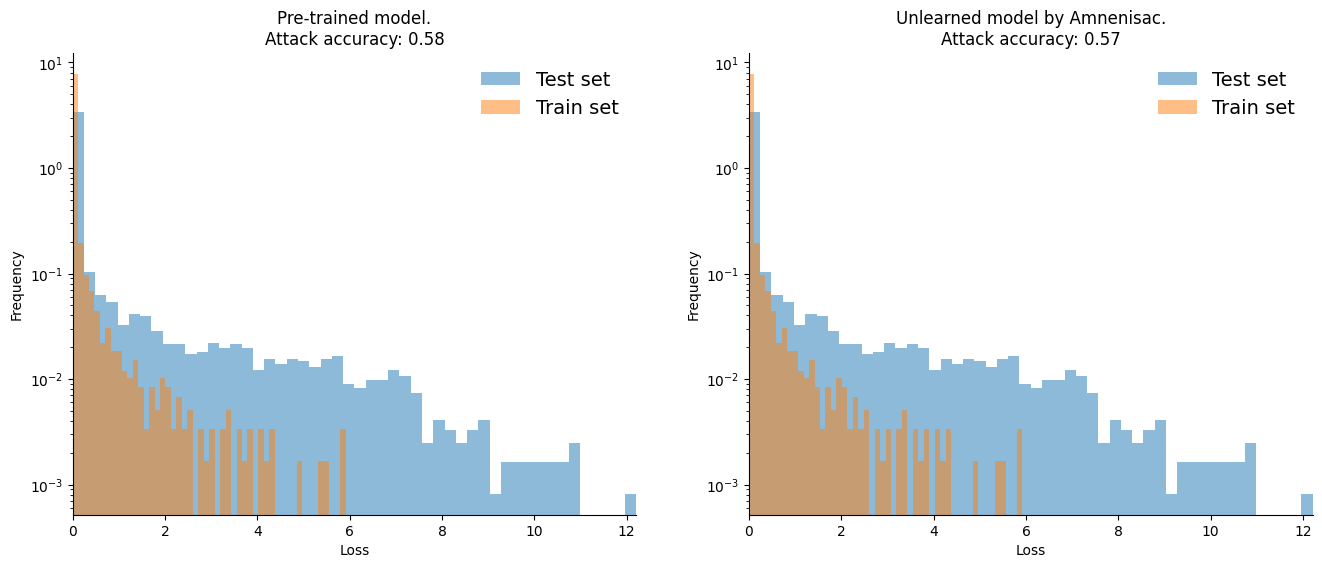

In [29]:
# forget_losses = test.compute_losses(model, forget_loader)

ft_forget_losses = test.compute_losses(scrub_final_model, forget_loader)
ft_test_losses = test.compute_losses(scrub_final_model, test_loader)

plot(ft_test_losses, ft_forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(model, test_loader, forget_loader):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Amnenisac.\nAttack accuracy: {test.MIA(scrub_final_model, test_loader, forget_loader):0.2f}"
    )

### Ditto

In [30]:
def train_distill_retain(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        loss = 0.4 * loss_cls + 0.6 * loss_div #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [31]:
def train_distill_forget(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()


        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        # loss = -loss_div  + logit_u - gamma * loss_cls
        loss = 1*loss_u #- 0.5*loss_div  - 0.5*loss_cls #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)


        # loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [32]:
def bad_train_distill_forget(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_b = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_b = model_b(input)
        with torch.no_grad():
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_b, target)
        loss_div = criterion_div(logit_b, logit_t)

        loss = - (0.5 * loss_cls + 0.5*loss_div)

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [33]:
def bad_train_distill_retain(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_b = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_b = model_b(input)
        with torch.no_grad():
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_b, target)
        loss_div = criterion_div(logit_b, logit_t)

        loss = 1 * loss_cls #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_b, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [34]:
def train_distill_fine_tune(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)

        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)

        loss = 1 * loss_cls

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

    return top1.avg, losses.avg

In [35]:
def bad_train(teacher, bad_teacher, retain_loader, forget_loader, validation_loader):
    opt = 'sgd'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 2
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 10
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_b = copy.deepcopy(bad_teacher)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_b, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_b)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_b)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0

        print("==> Bad Training Forget ...")
#         maximize_loss = bad_train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, \
#                                       swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
#                                       distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
        train_acc, train_loss = bad_train_distill_retain(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, \
                                          distill, gamma, alpha, beta, smoothing, split="minimize",)
        print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))



        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_b.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    model_b_final = copy.deepcopy(model_b)



    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_b_final

In [36]:
def teacher_train_distill_retain(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        loss = 0.7 * loss_cls + 0.3 * loss_div + 0.5*loss_u#opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [37]:
def teacher_train_distill_forget(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()


        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        # loss = -loss_div  + logit_u - gamma * loss_cls
        loss = - (loss_div + loss_cls) + 0.5*loss_u #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)


        # loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [38]:
def fine_tune(teacher, student, unlearn_model, retain_loader, forget_loader, validation_loader):
    opt = 'adam'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 4
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(student).eval()
    model_s = copy.deepcopy(teacher).train()

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        if epoch <= msteps:
            print("==> Teacher unlearn ...")
            maximize_loss = teacher_train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, unlearn_model = unlearn_model, \
                                               swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                               distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
            train_acc, train_loss = teacher_train_distill_retain(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                                  distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
        else:
            print("==> Teacher finetuning ...")
            train_acc, train_loss = train_distill_fine_tune(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("finetuning loss: {:.2f}\t train_acc: {}".format(train_loss, train_acc))

        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_s.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    model_s_final = copy.deepcopy(model_s)


    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_s_final

In [39]:
#Test 10k dollar

import copy
import time
from matplotlib import pyplot as plt
from torch import optim

def scrub(teacher, student, unlearn_model, retain_loader, forget_loader, validation_loader):
    opt = 'adam'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 4
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= msteps:
            print("==> SCRUB unlearning ...")
            maximize_loss = train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, unlearn_model = unlearn_model, \
                                          swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                          distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
            train_acc, train_loss = train_distill_retain(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))

        if epoch > msteps:
            print("==> SCRUB finetuning ...")
            train_acc, train_loss = train_distill_fine_tune(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("finetuning loss: {:.2f}\t train_acc: {}".format(train_loss, train_acc))

        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_s.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    #selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(lst_model[selected_idx - 1])


    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_s, model_s_final

#### Evaluation

In [40]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """

    teacher = copy.deepcopy(net)
    student = copy.deepcopy(net)
    bad_teacher = resnet18(weights=None, num_classes=10).to(DEVICE)

    #---------- BAD TRAIN ----------#
    bad_teacher = bad_train(teacher, bad_teacher, retain, forget, validation)
    #---------- FINE TUNE ----------#
    fine_tune(teacher, student, bad_teacher, retain, forget, validation)

    model_s, model_s_final = scrub(teacher, student, bad_teacher, retain, forget, validation)


    model_s.eval()
    return model_s

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.94	 train_acc: 29.31333351135254
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.56	 train_acc: 43.253334045410156
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.40	 train_acc: 49.36222457885742
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.28	 train_acc: 54.00222396850586
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.18	 train_acc: 58.217777252197266
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.08	 train_acc: 61.80889129638672
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 0.99	 train_acc: 65.58444213867188
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 0.90	 train_acc: 68.98444366455078
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 0.81	 train_acc: 72.58222198486328
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 0.71	 train_acc: 76.24888610839844
310.7437

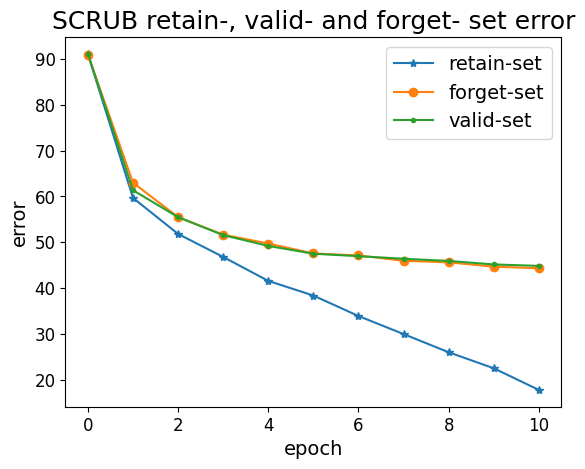

==> Teacher unlearn ...
maximize loss: -5.22	 minimize loss: 1.28	 train_acc: 48.9466667175293
==> Teacher unlearn ...
maximize loss: -6.41	 minimize loss: 1.57	 train_acc: 40.3466682434082
==> Teacher unlearn ...
maximize loss: -6.99	 minimize loss: 1.71	 train_acc: 32.4555549621582
==> Teacher unlearn ...
maximize loss: -7.41	 minimize loss: 1.88	 train_acc: 28.0755558013916
==> Teacher finetuning ...
finetuning loss: 1.17	 train_acc: 57.32444381713867
176.5198531150818


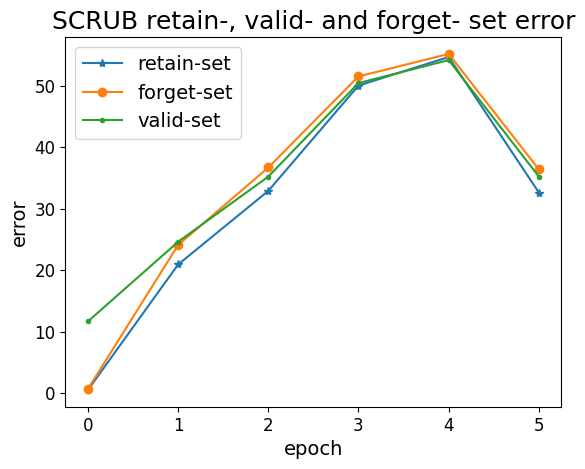

==> SCRUB unlearning ...
maximize loss: 0.01	 minimize loss: 0.08	 train_acc: 93.02889251708984
==> SCRUB unlearning ...
maximize loss: 0.01	 minimize loss: 0.04	 train_acc: 96.83555603027344
==> SCRUB unlearning ...
maximize loss: 0.01	 minimize loss: 0.04	 train_acc: 97.304443359375
==> SCRUB unlearning ...
maximize loss: 0.02	 minimize loss: 0.03	 train_acc: 97.45999908447266
==> SCRUB finetuning ...
finetuning loss: 0.22	 train_acc: 92.47333526611328
176.6117660999298
the selected index is 5


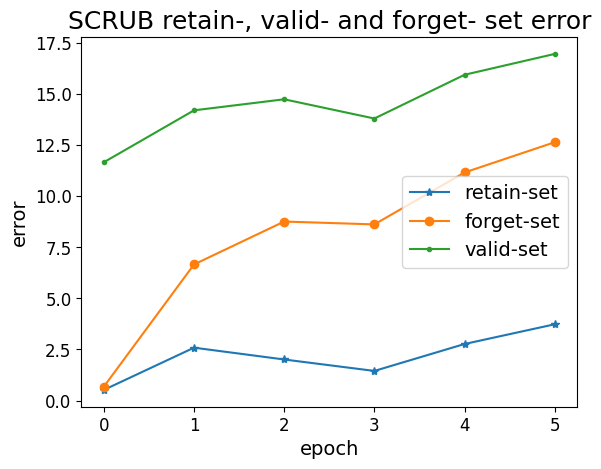

CPU times: user 3min 56s, sys: 19.6 s, total: 4min 16s
Wall time: 11min 5s


In [41]:
%%time
ditto = resnet18(weights=None, num_classes=10)
ditto.load_state_dict(weights_pretrained)
ditto.to(DEVICE)


# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ditto = unlearning(ditto, retain_loader, forget_loader, test_loader)

In [42]:
print(f"Retain set accuracy: {100.0 * accuracy(ditto, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ditto, test_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ditto, forget_loader):0.1f}%")

Retain set accuracy: 96.3%
Test set accuracy: 83.0%
Forget set accuracy: 87.4%


In [ ]:
forget_losses = test.compute_losses(model, forget_loader)

ft_forget_losses = test.compute_losses(ditto, forget_loader)
ft_test_losses = test.compute_losses(ditto, test_loader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(model, test_loader, forget_loader):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model.\nAttack accuracy: {test.MIA(ditto, test_loader, forget_loader):0.2f}"
    )

### Pikachu

In [44]:
def train_distill_forget(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()


        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        # loss = -loss_div  + logit_u - gamma * loss_cls
        loss = 1*loss_u - 0.5*loss_div  - 0.5*loss_cls #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)


        # loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [45]:
def train_distill_retain(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        loss = 0.3 * loss_cls + 0.7 * loss_div #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [46]:
def train_distill_fine_tune(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)

        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)

        loss = 1 * loss_cls

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

    return top1.avg, losses.avg

In [47]:
#Test 10k dollar

import copy
import time
from matplotlib import pyplot as plt
from torch import optim

def scrub(teacher, student, unlearn_model, retain_loader, forget_loader, validation_loader):
    opt = 'adam'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 2
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= msteps:
            print("==> SCRUB unlearning ...")
            maximize_loss = train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, unlearn_model = unlearn_model, \
                                          swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                          distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
            train_acc, train_loss = train_distill_retain(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))

        if epoch > msteps:
            print("==> SCRUB finetuning ...")
            train_acc, train_loss = train_distill_fine_tune(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("finetuning loss: {:.2f}\t train_acc: {}".format(train_loss, train_acc))

        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_s.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    #selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(lst_model[selected_idx - 1])


    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_s, model_s_final

In [48]:
def bad_train_distill(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_b = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_b = model_b(input)
        with torch.no_grad():
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_b, target)
        loss_div = criterion_div(logit_b, logit_t)

        loss = - (1 * loss_cls + 1*loss_div)

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [49]:
def bad_train(teacher, bad_teacher, retain_loader, forget_loader, validation_loader):
    opt = 'sgd'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 2
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_b = copy.deepcopy(bad_teacher)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_b, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_b)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_b)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0

        print("==> Bad Training ...")
        maximize_loss = bad_train_distill(epoch = epoch, train_loader = forget_loader, module_list = module_list, \
                                      swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                      distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
        print ("maximize loss: {:.2f}\t".format(maximize_loss))


        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_b.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    model_b_final = copy.deepcopy(model_b)



    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_b_final

In [50]:
def fine_tune(
    net,
    retain_loader,
    forget_loader,
    val_loader):
    """Simple unlearning by finetuning."""
    epochs = 1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs)
    net.train()

    for ep in range(epochs):
        net.train()
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()

In [51]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """

    student = copy.deepcopy(net)
    teacher = copy.deepcopy(net)
    bad_teacher = resnet18(weights=None, num_classes=10).to(DEVICE)

# ---------------- FINE TUNE ----------------- #
    fine_tune(teacher, retain, forget, validation)
#----------------- BAD TRAIN ---------------#
    bad_teacher = bad_train(teacher, bad_teacher, retain, forget, validation)
# ---------------- SCRUB ----------------- #
    model_s, model_s_final = scrub(teacher, student, bad_teacher, retain, forget, validation)


    model_s.eval()
    return model_s



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


==> Bad Training ...
maximize loss: -3.19	
==> Bad Training ...
maximize loss: -14.49	
==> Bad Training ...
maximize loss: -51.36	
==> Bad Training ...
maximize loss: -131.94	
==> Bad Training ...
maximize loss: -242.52	
101.4700825214386


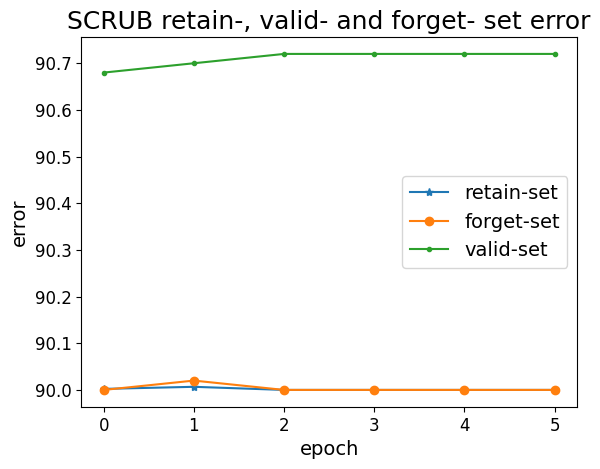

==> SCRUB unlearning ...
maximize loss: -2.57	 minimize loss: 0.61	 train_acc: 48.3377799987793
==> SCRUB unlearning ...
maximize loss: -3.09	 minimize loss: 0.65	 train_acc: 43.31999969482422
==> SCRUB finetuning ...
finetuning loss: 0.49	 train_acc: 83.0
==> SCRUB finetuning ...
finetuning loss: 0.20	 train_acc: 93.25333404541016
==> SCRUB finetuning ...
finetuning loss: 0.09	 train_acc: 96.91333770751953
170.10930061340332
the selected index is 5


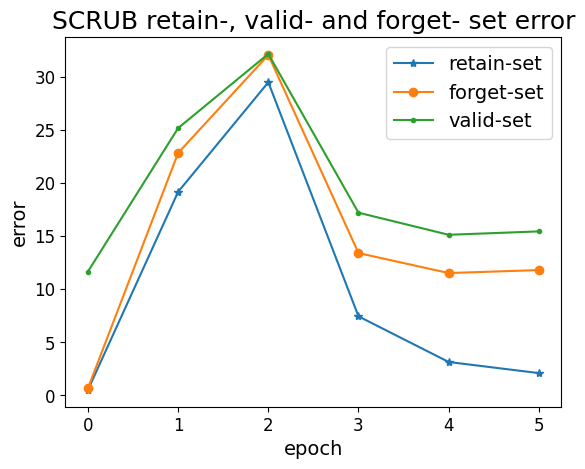

CPU times: user 1min 23s, sys: 9.13 s, total: 1min 32s
Wall time: 4min 46s


In [52]:
%%time
pikachu = resnet18(weights=None, num_classes=10)
pikachu.load_state_dict(weights_pretrained)
pikachu.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
pikachu = unlearning(pikachu, retain_loader, forget_loader, test_loader)

In [53]:
print(f"Retain set accuracy: {100.0 * accuracy(pikachu, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(pikachu, test_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(pikachu, forget_loader):0.1f}%")

Retain set accuracy: 97.9%
Test set accuracy: 84.6%
Forget set accuracy: 88.2%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


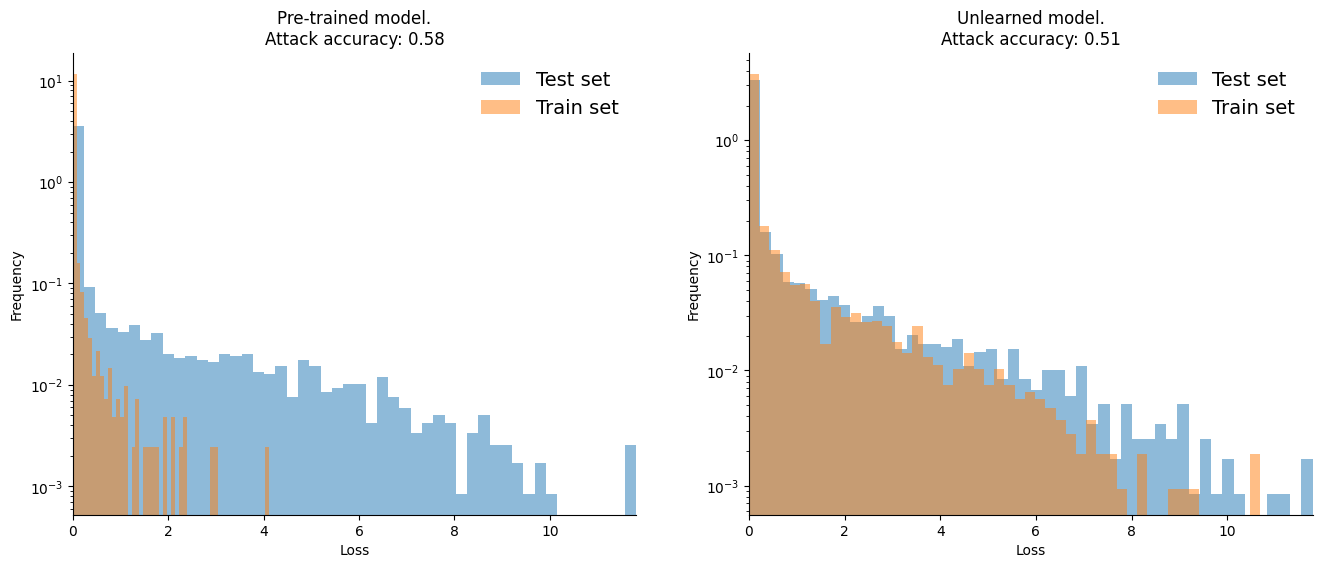

In [54]:
forget_losses = test.compute_losses(model, forget_loader)

ft_forget_losses = test.compute_losses(pikachu, forget_loader)
ft_test_losses = test.compute_losses(pikachu, test_loader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(model, test_loader, forget_loader):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model.\nAttack accuracy: {test.MIA(pikachu, test_loader, forget_loader):0.2f}"
    )

# MUFAC

Download MUFAC Dataset

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

Import Libaries

In [ ]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

Preprocessing data

In [ ]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

Create dataset

In [ ]:
class MUFAC(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = MUFAC(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MUFAC(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset = MUFAC(unseen_meta_data, unseen_image_directory, unseen_transform)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)


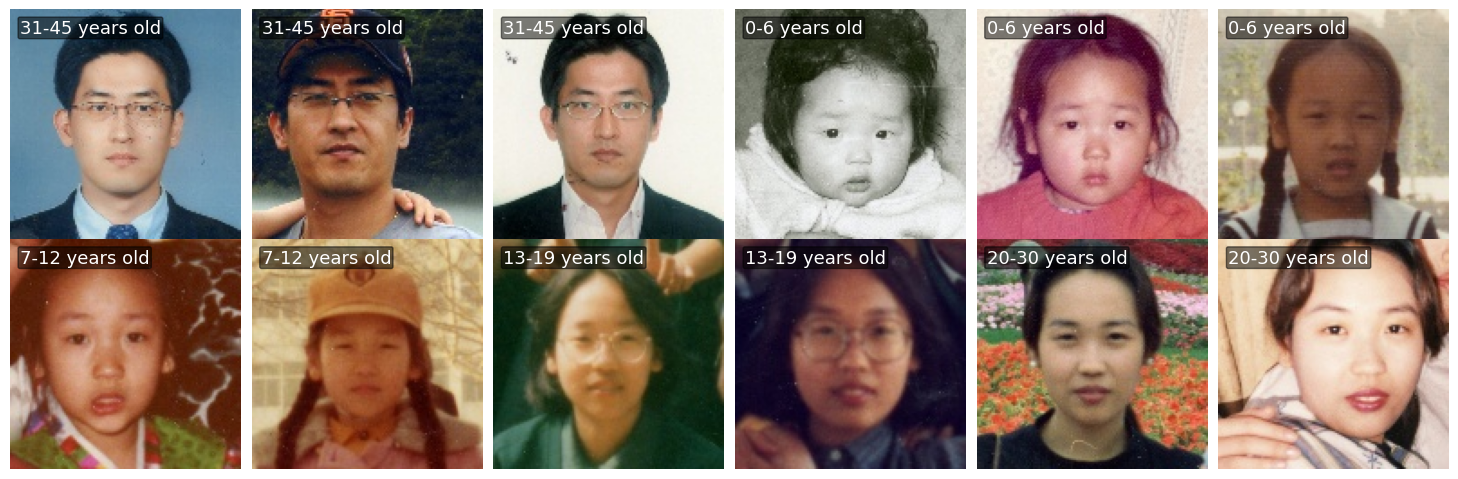

In [ ]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [ ]:
# @torch.no_grad()
# def evaluation(model, data_loader):
#     start_time = time.time()
#     print(f'[Test]')
#     model.eval()
#     total = 0
#     running_loss = 0.0
#     running_corrects = 0
#     running_top2_corrects = 0
#     log_step = 20

#     for i, batch in enumerate(data_loader):
#         imgs, labels = batch
#         imgs, labels = imgs.cuda(), labels.cuda()

#         with torch.no_grad():
#             outputs = model(imgs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             # Top-2 accuracy.
#             _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.  #Why?????????????????????????????????????
#             top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
#             running_top2_corrects += top2_correct.any(dim=1).sum().item()

#         total += labels.shape[0]
#         running_loss += loss.item()
#         running_corrects += torch.sum(preds == labels.data).item()

#         if (i == 0) or (i % log_step == log_step - 1):
#             print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

#     print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
#     print("elapsed time:", time.time() - start_time)
#     return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

# def set_seed(seed=42):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)
#     random.seed(seed)

In [ ]:
# def compute_losses(net, loader):
#     criterion = nn.CrossEntropyLoss(reduction="none")
#     all_losses = []

#     for inputs, y in loader:
#         targets = y
#         inputs, targets = inputs.cuda(), targets.cuda()

#         logits = net(inputs)

#         losses = criterion(logits, targets).cpu().detach().numpy()
#         for l in losses:
#             all_losses.append(l)

#     return np.array(all_losses)

# def simple_mia(sample_loss, members, n_splits=10, random_state=0):
#     unique_members = np.unique(members)
#     if not np.all(unique_members == np.array([0, 1])):
#         raise ValueError("members should only have 0 and 1s")

#     attack_model = linear_model.LogisticRegression()
#     cv = model_selection.StratifiedShuffleSplit(
#         n_splits=n_splits, random_state=random_state
#     )
#     return model_selection.cross_val_score(
#         attack_model, sample_loss, members, cv=cv, scoring="accuracy"
#     )

# def cal_mia(model):
#     set_seed(42)

#     forget_losses = compute_losses(model, forget_dataloader_test)
#     unseen_losses = compute_losses(model, unseen_dataloader)

#     np.random.shuffle(forget_losses)
#     forget_losses = forget_losses[: len(unseen_losses)]

#     samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
#     labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

#     mia_scores = simple_mia(samples_mia, labels_mia)
#     forgetting_score = abs(0.5 - mia_scores.mean())

#     return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}


Get the pretrained model

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1 -O pre_trained_last_checkpoint_epoch_30.pth

--2024-05-11 03:47:04--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1 [following]
--2024-05-11 03:47:04--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44803358 (43M) [application/octet-stream]
Saving to: ‘pre_trained_last_checkpoint_epoch_30.pth’

pre_trained_last_ch 10

In [ ]:
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'

In [ ]:
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))

<All keys matched successfully>

In [ ]:
unlearned_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
forget_dataset_train = MUFAC(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = MUFAC(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = MUFAC(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retain_dataset_test = MUFAC(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False)

In [ ]:
# print('Train dataset size:', len(train_dataset))
# print('Test dataset size:', len(test_dataset))
# print('Forget dataset size:', len(forget_dataset_train))
# print('Retain dataset size:', len(retain_dataset_train))
# print('Unseen dataset size:', len(unseen_dataset))

In [ ]:
# # Checking for duplicates across datasets
# train_image_paths = [x[0] for x in train_dataset.image_age_list]
# test_image_paths = [x[0] for x in test_dataset.image_age_list]
# forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
# retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
# unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

# train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
# train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
# train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
# train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
# test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
# test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
# test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
# forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
# forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
# retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

# overlap_dict = {
#     'train_test': train_test_overlap,
#     'train_forget': train_forget_overlap,
#     'train_retain': train_retain_overlap,
#     'train_unseen': train_unseen_overlap,
#     'test_forget': test_forget_overlap,
#     'test_retain': test_retain_overlap,
#     'test_unseen': test_unseen_overlap,
#     'forget_retain': forget_retain_overlap,
#     'forget_unseen': forget_unseen_overlap,
#     'retain_unseen': retain_unseen_overlap
# }
# overlap_dict

In [ ]:
# # print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# # original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
# original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
# original_model = models.resnet18(pretrained=False)
# num_features = original_model.fc.in_features
# original_model.fc = nn.Linear(num_features, 8)
# original_model.load_state_dict(torch.load(original_save_path))
# original_model = original_model.cuda()
# criterion = nn.CrossEntropyLoss()

# test_acc = evaluation(original_model, test_dataloader)
# test_acc

# set_seed(42)

# # Performance
# test_acc = evaluation(original_model, test_dataloader)
# unseen_acc = evaluation(original_model, unseen_dataloader)
# mia = cal_mia(original_model.cuda())
# print()
# print(f'Test Acc: {test_acc}')
# print(f'Unseen Acc: {unseen_acc}')
# print(f'MIA: {mia}')
# print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

# test_acc = evaluation(unlearned_model, test_dataloader)
# test_acc

In [ ]:
# set_seed(42)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

# num_epochs = 2
# for epoch in range(num_epochs):
#     running_loss = 0

#     for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
#         y_retain = y_retain.cuda()

#         # Classification Loss
#         outputs_retain = unlearned_model(x_retain.cuda())
#         classification_loss = criterion(outputs_retain, y_retain)

#         optimizer.zero_grad()
#         classification_loss.backward()
#         optimizer.step()

#         running_loss += classification_loss.item() * x_retain.size(0)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

#     average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
#     print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")


In [ ]:
# # Performance
# test_acc = evaluation(unlearned_model, test_dataloader)
# unseen_acc = evaluation(unlearned_model, unseen_dataloader)
# mia = cal_mia(unlearned_model.cuda())
# print()
# print(f'Test Acc: {test_acc}')
# print(f'Unseen Acc: {unseen_acc}')
# print(f'MIA: {mia}')
# print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

In [ ]:
# # print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# # original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
# original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
# unlearned_model = models.resnet18(pretrained=False)
# num_features = unlearned_model.fc.in_features
# unlearned_model.fc = nn.Linear(num_features, 8)
# unlearned_model.load_state_dict(torch.load(original_save_path))
# cf_model = unlearned_model.cuda()
# criterion = nn.CrossEntropyLoss()

In [ ]:
# # Print a weight set of a front layer in the network to check the freezing.
# print(unlearned_model.layer1[0].conv1.weight[0][0])

In [ ]:
# set_seed(42)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, unlearned_model.parameters()), lr=0.001)

# # Freeze all the parameters.
# for param in unlearned_model.parameters():
#     param.requires_grad = False

# # Only unfreeze the last three layers for the fine-tuning.
# for param in unlearned_model.layer3.parameters():
#     param.requires_grad = True
# for param in unlearned_model.layer4.parameters():
#     param.requires_grad = True
# for param in unlearned_model.avgpool.parameters():
#     param.requires_grad = True
# for param in unlearned_model.fc.parameters():
#     param.requires_grad = True

# num_epochs = 2

# for epoch in range(num_epochs):
#     running_loss = 0

#     for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
#         y_retain = y_retain.cuda()

#         # Classification Loss
#         outputs_retain = unlearned_model(x_retain.cuda())
#         classification_loss = criterion(outputs_retain, y_retain)

#         optimizer.zero_grad()
#         classification_loss.backward()
#         optimizer.step()

#         running_loss += classification_loss.item() * x_retain.size(0)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

#     average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
#     print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")


In [ ]:
# # Performance
# test_acc = evaluation(unlearned_model, test_dataloader)
# unseen_acc = evaluation(unlearned_model, unseen_dataloader)
# mia = cal_mia(unlearned_model.cuda())
# print(f'Test Acc: {test_acc}')
# print(f'Unseen Acc: {unseen_acc}')
# print(f'MIA: {mia}')
# print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


In [ ]:
# # Print a weight set of a front layer in the network to check the freezing.
# print(unlearned_model.layer1[0].conv1.weight[0][0])

#### Load pretrained model

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
cf_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
DEVICE = "cuda"

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(unlearned_model, retain_dataloader_train):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(unlearned_model, test_dataloader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(unlearned_model, forget_dataloader_train):0.1f}%")

Retain set accuracy: 96.2%
Test set accuracy: 55.8%
Forget set accuracy: 95.3%


#### MIA

In [ ]:
class cal_MIA:
  def __init__(self, DEVICE):
    self.DEVICE = DEVICE
  def compute_losses(self, net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(self.DEVICE), targets.to(self.DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


  def simple_mia(self, sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )
  def MIA(self, model, A_loader, B_loader):
    A_losses = self.compute_losses(model, A_loader)
    B_losses = self.compute_losses(model, B_loader)

    # make sure we have a balanced dataset for the MIA
    if len(A_losses) > len(B_losses):
      np.random.shuffle(A_losses)
      A_losses = A_losses[: len(B_losses)]
    elif len(A_losses) < len(B_losses):
      np.random.shuffle(B_losses)
      B_losses = B_losses[: len(A_losses)]

    ft_samples_mia = np.concatenate((A_losses, B_losses)).reshape((-1, 1))
    labels_mia = [0] * len(A_losses) + [1] * len(B_losses)

    ft_mia_scores = self.simple_mia(ft_samples_mia, labels_mia)
    return ft_mia_scores.mean()

In [ ]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [ ]:
def plot(A_losses, B_losses, first_title, first_losses_label, second_losses_label, C_losses = None, D_losses = None,
         second_title = None):
  """
  2 options: plot 1 charts or plot 2 charts

  A_losses and C_losses must have the similiar pattern.

  """
  if(C_losses.any() == None and D_losses.any() == None and second_title == None):
    fig, ax1 = plt.subplots(1,1)
  else:
    assert(C_losses.any() != None and D_losses.any() != None and second_title != None)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  ax1.set_title(first_title)
  ax1.hist(A_losses, density=True, alpha=0.5, bins=50, label=first_losses_label)
  ax1.hist(B_losses, density=True, alpha=0.5, bins=50, label=second_losses_label)
  ax1.set_xlabel("Loss")
  ax1.set_ylabel("Frequency")
  ax1.set_yscale("log")
  ax1.set_xlim((0, np.max(A_losses)))
  ax1.spines["top"].set_visible(False)
  ax1.spines["right"].set_visible(False)
  ax1.legend(frameon=False, fontsize=14)

  if(C_losses.any() != None and D_losses.any() != None and second_title != None):
    ax2.set_title(second_title)
    ax2.hist(C_losses, density=True, alpha=0.5, bins=50, label=first_losses_label)
    ax2.hist(D_losses, density=True, alpha=0.5, bins=50, label=second_losses_label)
    ax2.set_xlabel("Loss")
    ax2.set_ylabel("Frequency")
    ax2.set_yscale("log")
    ax2.set_xlim((0, np.max(C_losses)))
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.legend(frameon=False, fontsize=14)

  plt.show()


#### Fine Tune

In [ ]:
def finetune(
    net,
    retain_loader,
    forget_loader,
    val_loader):
    """Simple unlearning by finetuning."""
    epochs = 1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs)
    net.train()

    for ep in range(epochs):
        net.train()
        for sample in retain_loader:
            inputs = sample[0]
            targets = sample[1]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()

In [ ]:
from copy import deepcopy

finetune_model = deepcopy(unlearned_model)

finetune(finetune_model, retain_dataloader_train, forget_dataloader_train, retain_dataloader_train)

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(finetune_model, retain_dataloader_train):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(finetune_model, test_dataloader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(finetune_model, forget_dataloader_train):0.1f}%")

Retain set accuracy: 96.7%
Test set accuracy: 58.7%
Forget set accuracy: 96.1%


In [ ]:
test = cal_MIA(DEVICE=DEVICE)
train_losses = test.compute_losses(unlearned_model, train_dataloader)
test_losses = test.compute_losses(unlearned_model, test_dataloader)

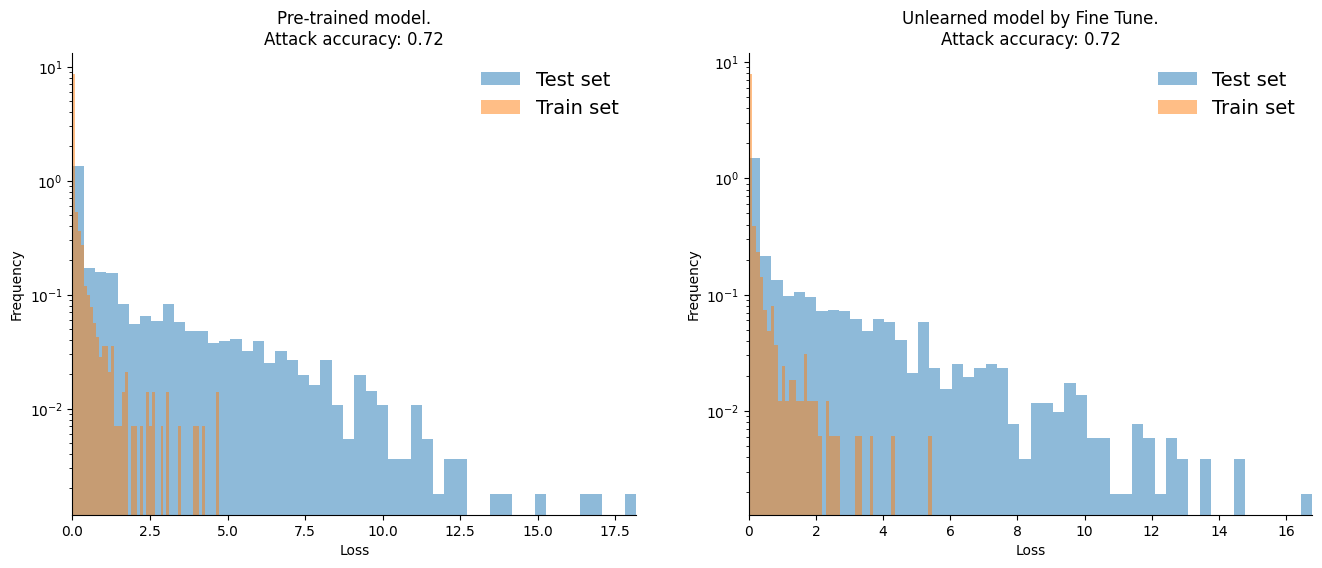

In [ ]:
forget_losses = test.compute_losses(unlearned_model, forget_dataloader_train)

ft_forget_losses = test.compute_losses(finetune_model, forget_dataloader_train)
ft_test_losses = test.compute_losses(finetune_model, test_dataloader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(unlearned_model, test_dataloader, forget_dataloader_train):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Fine Tune.\nAttack accuracy: {test.MIA(finetune_model, test_dataloader, forget_dataloader_train):0.2f}"
    )

#### Amnesiac


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def training_step(model, batch, device):
    images, labels = batch
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    out = model(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    return loss



def validation_epoch_end(model, outputs):
    batch_losses = [x["Loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
    batch_accs = [x["Acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
    return {"Loss": epoch_loss.item(), "Acc": epoch_acc.item()}

@torch.no_grad()
# def evaluate(model, val_loader, device):
#     model.eval()
#     outputs = [validation_step(model, batch, device) for batch in val_loader]
#     return validation_epoch_end(model, outputs)

def epoch_end(model, epoch, result):
    print(
        "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,
            result["lrs"][-1],
            result["train_loss"],
            result["Loss"],
            result["Acc"],
        )
    )

def fit_one_unlearning_cycle(epochs, model, train_loader, lr, device):
    history = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch, device)
            loss.backward()
            train_losses.append(loss.detach().cpu())

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))

In [ ]:
import random

def amnesiac(
    model,
    retain_train_dl,
    forget_train_dl,
    num_classes,
    device = DEVICE,
    **kwargs,
):
    unlearninglabels = list(range(num_classes))
    unlearning_trainset = []

    for x, label in forget_train_dl.dataset:
        rnd = random.choice(unlearninglabels)
        while rnd == label:
            rnd = random.choice(unlearninglabels)
        unlearning_trainset.append((x, rnd))

    for x, y in retain_train_dl.dataset:
        unlearning_trainset.append((x, y))

    unlearning_train_set_dl = DataLoader(
        unlearning_trainset, batch_size, pin_memory=True, shuffle=True
    )

    _ = fit_one_unlearning_cycle(
        4, model, unlearning_train_set_dl, device=device, lr=0.0001
    )

In [ ]:
%%time

amnesiac_model = deepcopy(unlearned_model)

amnesiac(amnesiac_model, retain_dataloader_train, forget_dataloader_train, 8)


CPU times: user 57.4 s, sys: 5.96 s, total: 1min 3s
Wall time: 1min 3s


In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(amnesiac_model, retain_dataloader_train):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(amnesiac_model, test_dataloader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(amnesiac_model, forget_dataloader_train):0.1f}%")

Retain set accuracy: 93.9%
Test set accuracy: 49.1%
Forget set accuracy: 59.1%


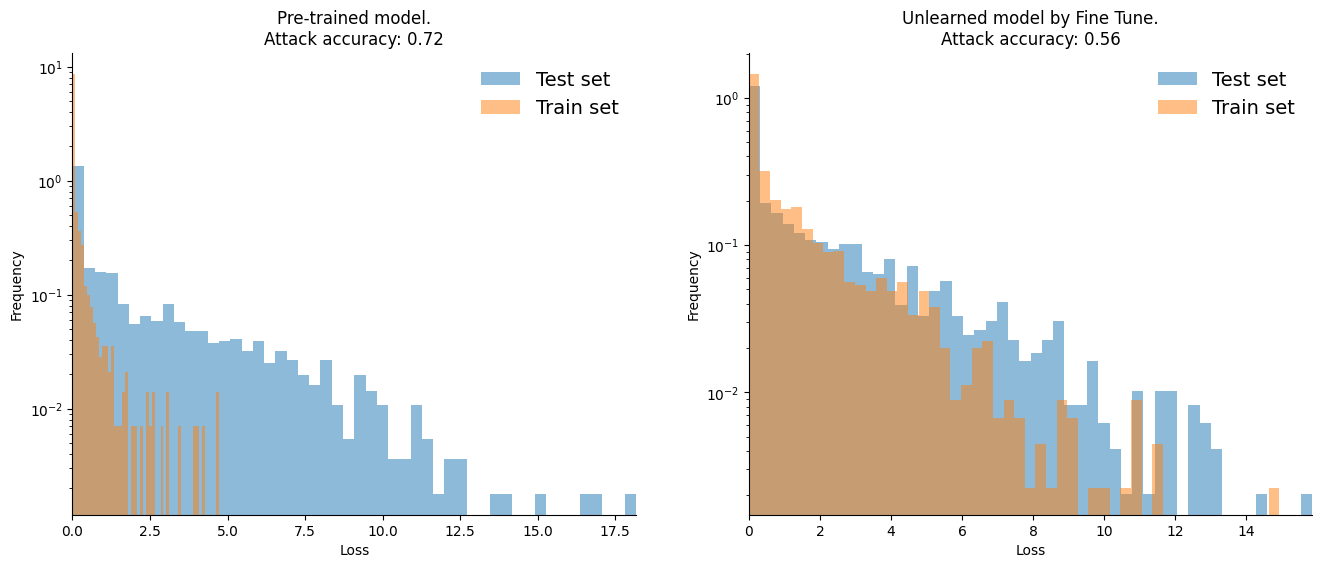

In [ ]:
# forget_losses = test.compute_losses(unlearned_model, forget_dataloader_train)

ft_forget_losses = test.compute_losses(amnesiac_model, forget_dataloader_train)
ft_test_losses = test.compute_losses(amnesiac_model, test_dataloader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(unlearned_model, test_dataloader, forget_dataloader_train):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Amnesiac.\nAttack accuracy: {test.MIA(amnesiac_model, test_dataloader, forget_dataloader_train):0.2f}"
    )

#### Scrub

In [ ]:
class DistillKL(nn.Module):
    """Distilling the Knowledge in a Neural Network"""
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='batchmean') * (self.T**2) / y_s.shape[0]
        return loss

def sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate,  optimizer):
    """Sets the learning rate to the initial LR decayed by decay rate every steep step"""
    steps = np.sum(epoch > np.asarray(lr_decay_epochs))
    new_lr = sgda_learning_rate
    if steps > 0:
        new_lr = sgda_learning_rate * (lr_decay_rate ** steps)
    return new_lr

def train_distill(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):
#         if distill in ['crd']:  #opt - done
#             input, target, index, contrast_idx = data
#         else:
        input, target = data
        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
#             if distill in ['crd']:   #opt
#                 contrast_idx = contrast_idx.cuda()
#                 index = index.cuda()

        # ===================forward=====================
        #feat_s, logit_s = model_s(input, is_feat=True, preact=False)
        logit_s = model_s(input)
        with torch.no_grad():
            #feat_t, logit_t = model_t(input, is_feat=True, preact=preact)
            #feat_t = [f.detach() for f in feat_t]
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)

        # other kd beyond KL divergence
        loss_kd = 0


        if split == "minimize":
            loss = gamma * loss_cls + alpha * loss_div + beta * loss_kd #opt
        elif split == "maximize":
            loss = -loss_div

        loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        if split == "minimize" and not quiet:
            acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
        elif split == "maximize" and not quiet:
            kd_losses.update(loss.item(), input.size(0))
        elif split == "linear" and not quiet:
            acc1, _ = scrub_accuracy(logit_s, target, topk=(1, 1))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            kd_losses.update(loss.item(), input.size(0))


        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    if split == "minimize":
        return top1.avg, losses.avg
    else:
        return kd_losses.avg

def validate(val_loader, model, criterion):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = scrub_accuracy(output, target, topk=(1, 5)) ## Error
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

    return top1.avg, top5.avg, losses.avg

def scrub_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def param_dist(model, swa_model, p):
    #This is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    dist = 0.
    for p1, p2 in zip(model.parameters(), swa_model.parameters()):
        dist += torch.norm(p1 - p2, p='fro')
    return p * dist

In [ ]:
import copy

def scrub(teacher, student, retain_loader, forget_loader):
    seed = 1
    opt = 'sgd'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 3
    clip = 0.2
    sstart = 10
    kd_T = 4
    lr = 0.01
    distill = 'kd'

    dataset = 'cifar10'
    model = 'resnet'

    sgda_epochs = 10
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    model_lst = []

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

#     forget_validation_loader = copy.deepcopy(validation_loader)

    ## Test
    # for i, j in forget_validation_loader:
    #   print(j)
    ##
    fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer) #Error

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        # acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        # acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= msteps:
            maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer,
                                          distill, gamma, alpha, beta, smoothing, "maximize")
        train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, "minimize",)
        if epoch >= sstart:
            swa_model.update_parameters(model_s)

        torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        # model_lst.append(model_s.state_dict())


        print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
    t2 = time.time()
    print (t2-t1)

    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    # selected_model = model_lst[selected_idx-1]
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(torch.load(selected_model))

    return model_s, model_s_final

In [ ]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
scrub_model = deepcopy(unlearned_model)
teacher = deepcopy(unlearned_model)

scrub_model.train()
teacher.eval()

scrub_current_model, scrub_final_model = scrub(teacher, scrub_model, retain_dataloader_train, forget_dataloader_train)

maximize loss: -0.00	 minimize loss: 0.15	 train_acc: 96.18768310546875
maximize loss: 0.09	 minimize loss: 0.16	 train_acc: 95.82404327392578
maximize loss: 0.02	 minimize loss: 0.15	 train_acc: 96.17594909667969
maximize loss: 0.00	 minimize loss: 0.16	 train_acc: 96.22286987304688
maximize loss: 0.00	 minimize loss: 0.16	 train_acc: 96.01172637939453
maximize loss: 0.00	 minimize loss: 0.16	 train_acc: 96.23460388183594
maximize loss: 0.00	 minimize loss: 0.15	 train_acc: 96.24633026123047
maximize loss: 0.00	 minimize loss: 0.16	 train_acc: 95.89442443847656
maximize loss: 0.00	 minimize loss: 0.16	 train_acc: 96.07038116455078
maximize loss: 0.00	 minimize loss: 0.16	 train_acc: 96.03518676757812
492.6826057434082
the selected index is 9


In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(scrub_current_model, retain_dataloader_train):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(scrub_current_model, test_dataloader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(scrub_current_model, forget_dataloader_train):0.1f}%")

Retain set accuracy: 95.9%
Test set accuracy: 55.5%
Forget set accuracy: 96.5%


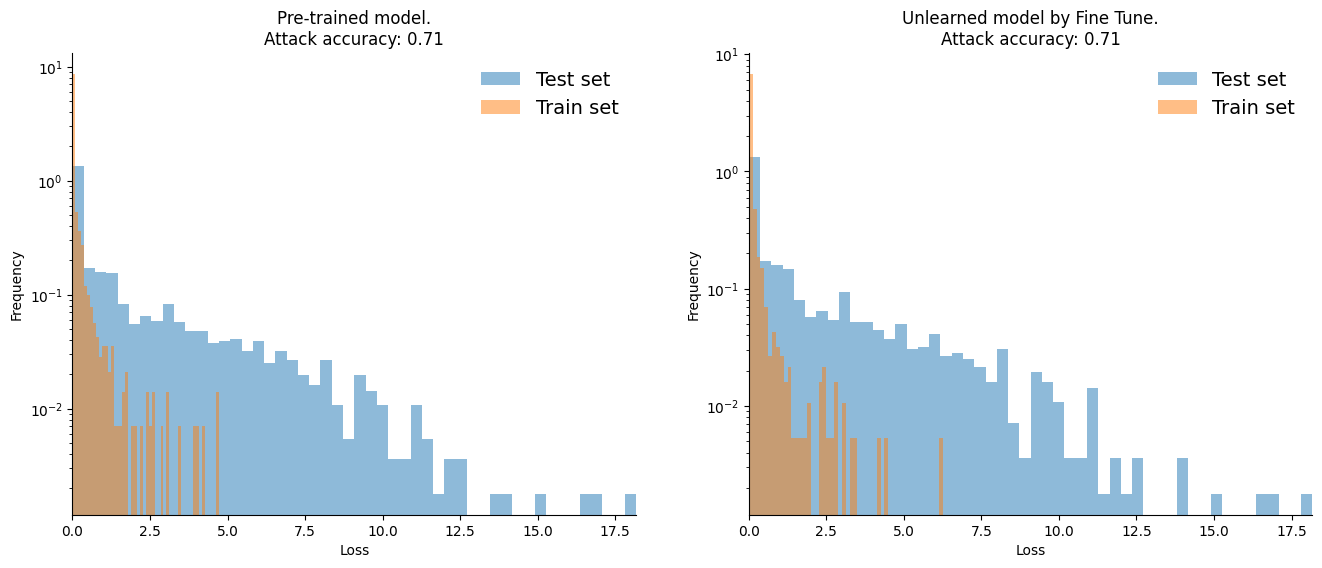

In [ ]:
# forget_losses = test.compute_losses(unlearned_model, forget_dataloader_train)

ft_forget_losses = test.compute_losses(scrub_final_model, forget_dataloader_train)
ft_test_losses = test.compute_losses(scrub_final_model, test_dataloader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(unlearned_model, test_dataloader, forget_dataloader_train):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Scrub.\nAttack accuracy: {test.MIA(scrub_final_model, test_dataloader, forget_dataloader_train):0.2f}"
    )

#### Ditto

In [ ]:
def train_distill_retain(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        loss = 0.4 * loss_cls + 0.6 * loss_div #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [ ]:
def train_distill_forget(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()


        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        # loss = -loss_div  + logit_u - gamma * loss_cls
        loss = 1*loss_u #- 0.5*loss_div  - 0.5*loss_cls #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)


        # loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [ ]:
def bad_train_distill_forget(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_b = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_b = model_b(input)
        with torch.no_grad():
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_b, target)
        loss_div = criterion_div(logit_b, logit_t)

        loss = - (0.5 * loss_cls + 0.5*loss_div)

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [ ]:
def bad_train_distill_retain(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_b = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_b = model_b(input)
        with torch.no_grad():
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_b, target)
        loss_div = criterion_div(logit_b, logit_t)

        loss = 1 * loss_cls #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_b, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [ ]:
def train_distill_fine_tune(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)

        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)

        loss = 1 * loss_cls

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

    return top1.avg, losses.avg

In [ ]:
def bad_train(teacher, bad_teacher, retain_loader, forget_loader, validation_loader):
    opt = 'sgd'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 2
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 10
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_b = copy.deepcopy(bad_teacher)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_b, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_b)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_b)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0

        print("==> Bad Training Forget ...")
#         maximize_loss = bad_train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, \
#                                       swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
#                                       distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
        train_acc, train_loss = bad_train_distill_retain(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, \
                                          distill, gamma, alpha, beta, smoothing, split="minimize",)
        print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))



        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_b.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    model_b_final = copy.deepcopy(model_b)



    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_b_final

In [ ]:
def teacher_train_distill_retain(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        loss = 0.7 * loss_cls + 0.3 * loss_div + 0.5*loss_u#opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [ ]:
def teacher_train_distill_forget(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()


        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        # loss = -loss_div  + logit_u - gamma * loss_cls
        loss = - (loss_div + loss_cls) + 0.5*loss_u #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)


        # loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [ ]:
def fine_tune(teacher, student, unlearn_model, retain_loader, forget_loader, validation_loader):
    opt = 'adam'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 4
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(student).eval()
    model_s = copy.deepcopy(teacher).train()

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        if epoch <= msteps:
            print("==> Teacher unlearn ...")
            maximize_loss = teacher_train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, unlearn_model = unlearn_model, \
                                               swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                               distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
            train_acc, train_loss = teacher_train_distill_retain(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                                  distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
        else:
            print("==> Teacher finetuning ...")
            train_acc, train_loss = train_distill_fine_tune(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("finetuning loss: {:.2f}\t train_acc: {}".format(train_loss, train_acc))

        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_s.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    model_s_final = copy.deepcopy(model_s)


    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_s_final

In [ ]:
#Test 10k dollar

import copy
import time
from matplotlib import pyplot as plt
from torch import optim

def scrub(teacher, student, unlearn_model, retain_loader, forget_loader, validation_loader):
    opt = 'adam'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 4
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= msteps:
            print("==> SCRUB unlearning ...")
            maximize_loss = train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, unlearn_model = unlearn_model, \
                                          swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                          distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
            train_acc, train_loss = train_distill_retain(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))

        if epoch > msteps:
            print("==> SCRUB finetuning ...")
            train_acc, train_loss = train_distill_fine_tune(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("finetuning loss: {:.2f}\t train_acc: {}".format(train_loss, train_acc))

        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_s.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    #selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(lst_model[selected_idx - 1])


    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_s, model_s_final

In [ ]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """

    teacher = copy.deepcopy(net)
    student = copy.deepcopy(net)
    # bad_teacher = resnet18(weights=None, num_classes=10).to(DEVICE)
    bad_teacher = models.resnet18(pretrained=False)
    num_features = bad_teacher.fc.in_features
    bad_teacher.fc = nn.Linear(num_features, 8)

    #---------- BAD TRAIN ----------#
    bad_teacher = bad_train(teacher, bad_teacher, retain, forget, validation)
    #---------- FINE TUNE ----------#
    fine_tune(teacher, student, bad_teacher, retain, forget, validation)

    model_s, model_s_final = scrub(teacher, student, bad_teacher, retain, forget, validation)


    model_s.eval()
    return model_s

==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.92	 train_acc: 22.56891441345215
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.88	 train_acc: 26.322580337524414
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.86	 train_acc: 27.870967864990234
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.81	 train_acc: 29.85337257385254
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.76	 train_acc: 32.750732421875
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.71	 train_acc: 34.33430862426758
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.66	 train_acc: 35.69501495361328
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.61	 train_acc: 37.75952911376953
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.56	 train_acc: 39.941349029541016
==> Bad Training Forget ...
maximize loss: 0.00	 minimize loss: 1.51	 train_acc: 41.067447662353516
530.9626

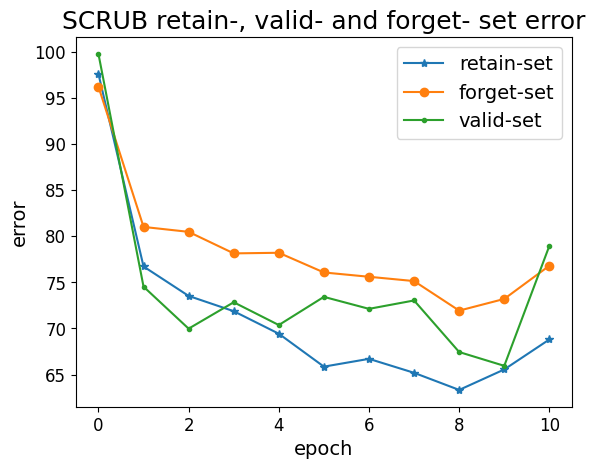

==> Teacher unlearn ...
maximize loss: -22.40	 minimize loss: 3.28	 train_acc: 35.74193572998047
==> Teacher unlearn ...
maximize loss: -8.72	 minimize loss: 3.36	 train_acc: 21.00879669189453
==> Teacher unlearn ...
maximize loss: -3.96	 minimize loss: 2.31	 train_acc: 20.93841552734375
==> Teacher unlearn ...
maximize loss: -3.21	 minimize loss: 2.05	 train_acc: 20.703811645507812
==> Teacher finetuning ...
finetuning loss: 1.67	 train_acc: 34.06451416015625
290.75505924224854


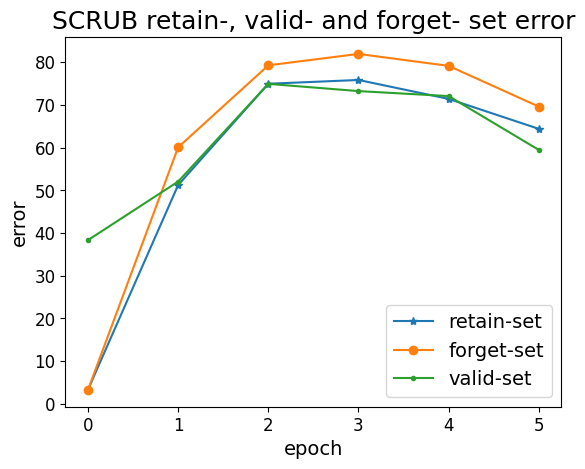

==> SCRUB unlearning ...
maximize loss: 0.03	 minimize loss: 0.41	 train_acc: 60.961875915527344
==> SCRUB unlearning ...
maximize loss: 0.04	 minimize loss: 0.37	 train_acc: 66.48680114746094
==> SCRUB unlearning ...
maximize loss: 0.05	 minimize loss: 0.36	 train_acc: 65.61876678466797
==> SCRUB unlearning ...
maximize loss: 0.04	 minimize loss: 0.32	 train_acc: 69.66568756103516
==> SCRUB finetuning ...
finetuning loss: 0.80	 train_acc: 67.7771224975586
291.8502914905548
the selected index is 5


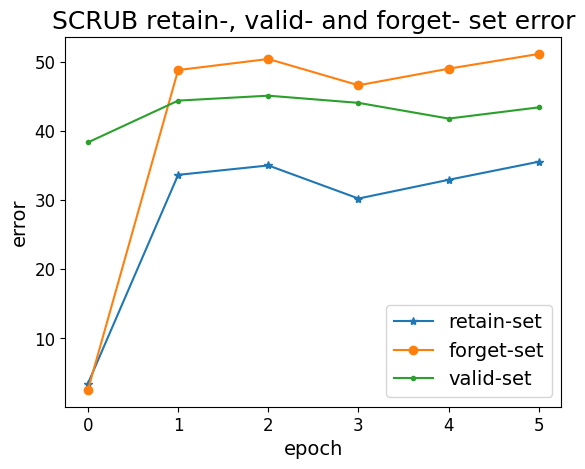

CPU times: user 17min 51s, sys: 17.7 s, total: 18min 9s
Wall time: 18min 34s


In [ ]:
%%time
ditto = deepcopy(unlearned_model)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ditto = unlearning(ditto, retain_dataloader_train, forget_dataloader_train, test_dataloader)

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(ditto, retain_dataloader_train):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ditto, test_dataloader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ditto, forget_dataloader_train):0.1f}%")

Retain set accuracy: 64.9%
Test set accuracy: 56.6%
Forget set accuracy: 48.8%


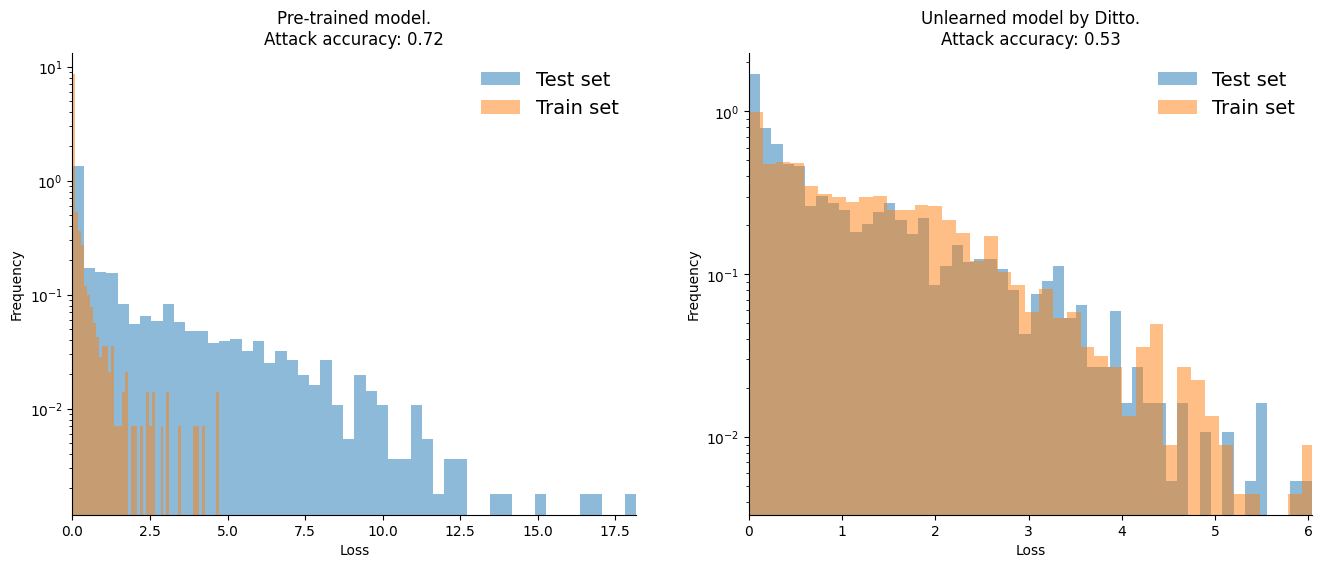

In [ ]:
# forget_losses = test.compute_losses(unlearned_model, forget_dataloader_train)

ft_forget_losses = test.compute_losses(ditto, forget_dataloader_train)
ft_test_losses = test.compute_losses(ditto, test_dataloader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(unlearned_model, test_dataloader, forget_dataloader_train):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Ditto.\nAttack accuracy: {test.MIA(ditto, test_dataloader, forget_dataloader_train):0.2f}"
    )

#### Pikachu

In [ ]:
def train_distill_forget(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()


        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        # loss = -loss_div  + logit_u - gamma * loss_cls
        loss = 1*loss_u - 0.5*loss_div  - 0.5*loss_cls #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)


        # loss = loss + param_dist(model_s, swa_model, smoothing) #opt

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [ ]:
def train_distill_retain(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]
    model_u = unlearn_model

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)
        with torch.no_grad():
            logit_t = model_t(input)
            logit_u = model_u(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)
        loss_u = criterion_div(logit_s, logit_u)

        # other kd beyond KL divergence
        loss_kd = 0

        loss = 0.3 * loss_cls + 0.7 * loss_div #opt

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()



    return top1.avg, losses.avg

In [ ]:
def train_distill_fine_tune(epoch, train_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_s = model_s(input)

        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)

        loss = 1 * loss_cls

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        acc1, _ = scrub_accuracy(logit_s, target, topk=(1,1))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

    return top1.avg, losses.avg

In [ ]:
#Test 10k dollar

import copy
import time
from matplotlib import pyplot as plt
from torch import optim

def scrub(teacher, student, unlearn_model, retain_loader, forget_loader, validation_loader):
    opt = 'adam'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 2
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_s, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= msteps:
            print("==> SCRUB unlearning ...")
            maximize_loss = train_distill_forget(epoch = epoch, train_loader = forget_loader, module_list = module_list, unlearn_model = unlearn_model, \
                                          swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                          distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
            train_acc, train_loss = train_distill_retain(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))

        if epoch > msteps:
            print("==> SCRUB finetuning ...")
            train_acc, train_loss = train_distill_fine_tune(epoch, retain_loader, module_list, unlearn_model, swa_model, criterion_list, optimizer,
                                              distill, gamma, alpha, beta, smoothing, split="minimize",)
            print ("finetuning loss: {:.2f}\t train_acc: {}".format(train_loss, train_acc))

        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_s.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_s, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    try:
        selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    #selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(lst_model[selected_idx - 1])


    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_s, model_s_final

In [ ]:
def bad_train_distill(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, distill, gamma, alpha, beta, smoothing,
                  split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_b = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    top1 = AverageMeter()


    end = time.time()
    for idx, data in enumerate(train_loader):

        input, target = data

        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        logit_b = model_b(input)
        with torch.no_grad():
            logit_t = model_t(input)


        # cls + kl div
        loss_cls = criterion_cls(logit_b, target)
        loss_div = criterion_div(logit_b, logit_t)

        loss = - (1 * loss_cls + 1*loss_div)

        # loss = loss + param_dist(model_s, swa_model, smoothing)

        kd_losses.update(loss.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()


    return kd_losses.avg

In [ ]:
def bad_train(teacher, bad_teacher, retain_loader, forget_loader, validation_loader):
    opt = 'sgd'
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 2
    clip = 0.2
    sstart = 10
    kd_T = 2
    lr = 0.01
    distill = 'kd'

    model = 'resnet'

    sgda_epochs = 5
    gda_batch_size = 128
    del_batch_size = 32
    sgda_learning_rate = 0.0005
    lr_decay_epochs = [3,5,9]
    lr_decay_rate = 0.1
    sgda_weight_decay = 5e-4
    sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_b = copy.deepcopy(bad_teacher)

    #this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    #For SGDA smoothing
    beta = 0.1
    def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
        1 - beta) * averaged_model_parameter + beta * model_parameter
    swa_model = torch.optim.swa_utils.AveragedModel(
        model_b, avg_fn=avg_fn)

    module_list = nn.ModuleList([])
    module_list.append(model_b)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_b)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import
    criterion_kd = DistillKL(kd_T)  # Import

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.SGD(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)
    if opt == "adam":
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              weight_decay=sgda_weight_decay)
    elif opt == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=sgda_learning_rate,
                              momentum=sgda_momentum,
                              weight_decay=sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
        swa_model.cuda()


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []

    # forget_validation_loader = copy.deepcopy(validation_loader)
    # fgt_cls = list(np.unique(forget_loader.targets[i] for i in forget_loader))


    # indices = [i in fgt_cls for i in forget_validation_loader]
    # forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    # forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]

    #scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    lst_model = []
    for epoch in range(1, sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, lr, lr_decay_epochs, sgda_learning_rate, lr_decay_rate, optimizer)

        acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
        acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
        # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0

        print("==> Bad Training ...")
        maximize_loss = bad_train_distill(epoch = epoch, train_loader = forget_loader, module_list = module_list, \
                                      swa_model = swa_model, criterion_list = criterion_list, optimizer=optimizer, \
                                      distill=distill, gamma=gamma, alpha=alpha, beta=beta, smoothing=smoothing, split="maximize")
        print ("maximize loss: {:.2f}\t".format(maximize_loss))


        #torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        lst_model.append(model_b.state_dict())


    acc_r, acc5_r, loss_r = validate(retain_loader, model_b, criterion_cls)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_b, criterion_cls)
    acc_v, acc5_v, loss_v = validate(validation_loader, model_b, criterion_cls)
    # acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
        # acc_fvs.append(100-acc_fv.item())
    t2 = time.time()
    print (t2-t1)

    model_b_final = copy.deepcopy(model_b)



    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title('SCRUB retain-, valid- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.show()

    return model_b_final

In [ ]:
def fine_tune(
    net,
    retain_loader,
    forget_loader,
    val_loader):
    """Simple unlearning by finetuning."""
    epochs = 1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs)
    net.train()

    for ep in range(epochs):
        net.train()
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()

In [ ]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """

    student = copy.deepcopy(net)
    teacher = copy.deepcopy(net)
    bad_teacher = models.resnet18(pretrained=False)
    num_features = bad_teacher.fc.in_features
    bad_teacher.fc = nn.Linear(num_features, 8)

# ---------------- FINE TUNE ----------------- #
    fine_tune(teacher, retain, forget, validation)
#----------------- BAD TRAIN ---------------#
    bad_teacher = bad_train(teacher, bad_teacher, retain, forget, validation)
# ---------------- SCRUB ----------------- #
    model_s, model_s_final = scrub(teacher, student, bad_teacher, retain, forget, validation)


    model_s.eval()
    return model_s



==> Bad Training ...
maximize loss: -5.69	
==> Bad Training ...
maximize loss: -35.17	
==> Bad Training ...
maximize loss: -91.61	
==> Bad Training ...
maximize loss: -202.64	
==> Bad Training ...
maximize loss: -359.51	
174.2739815711975


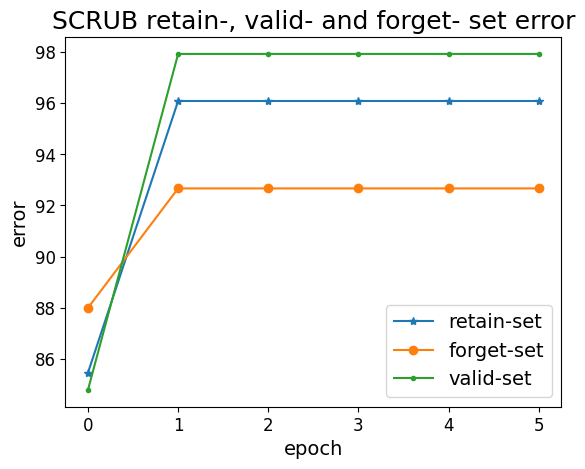

==> SCRUB unlearning ...
maximize loss: -10.27	 minimize loss: 1.45	 train_acc: 39.91788864135742
==> SCRUB unlearning ...
maximize loss: -6.44	 minimize loss: 1.32	 train_acc: 21.325511932373047
==> SCRUB finetuning ...
finetuning loss: 1.87	 train_acc: 27.54252052307129
==> SCRUB finetuning ...
finetuning loss: 1.32	 train_acc: 46.88562774658203
==> SCRUB finetuning ...
finetuning loss: 1.03	 train_acc: 57.57184600830078
273.91277551651
the selected index is 5


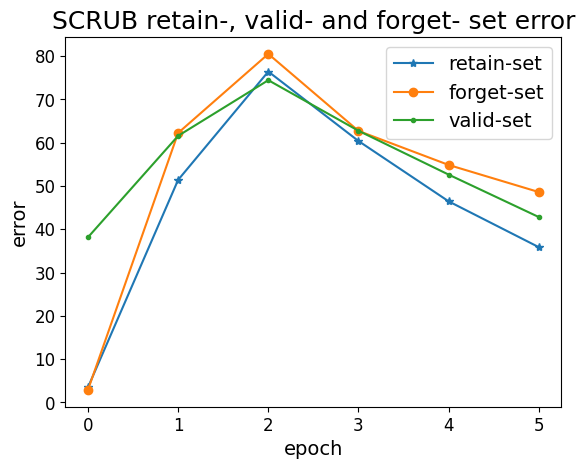

CPU times: user 7min 37s, sys: 8 s, total: 7min 45s
Wall time: 7min 49s


In [ ]:
%%time
pikachu = deepcopy(unlearned_model)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
pikachu = unlearning(pikachu, retain_dataloader_train, forget_dataloader_train, test_dataloader)

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(pikachu, retain_dataloader_train):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(pikachu, test_dataloader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(pikachu, forget_dataloader_train):0.1f}%")

Retain set accuracy: 63.1%
Test set accuracy: 57.2%
Forget set accuracy: 51.5%


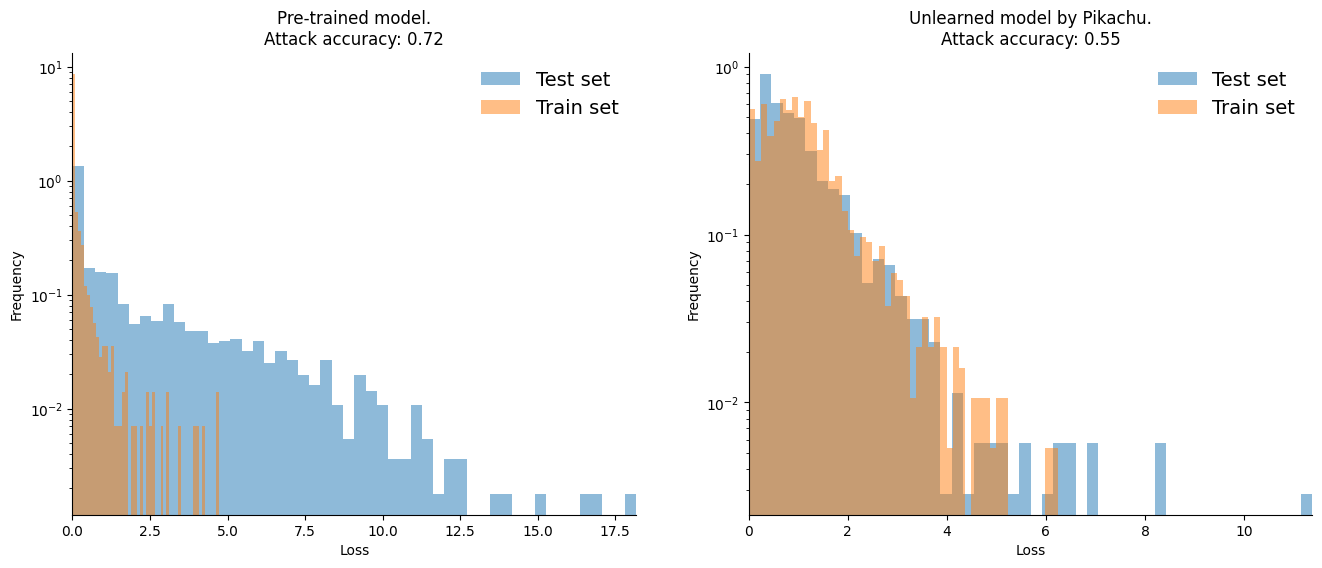

In [ ]:
# forget_losses = test.compute_losses(unlearned_model, forget_dataloader_train)

ft_forget_losses = test.compute_losses(pikachu, forget_dataloader_train)
ft_test_losses = test.compute_losses(pikachu, test_dataloader)

plot(test_losses, forget_losses, f"Pre-trained model.\nAttack accuracy: {test.MIA(unlearned_model, test_dataloader, forget_dataloader_train):0.2f}", "Test set", "Train set" , \
    C_losses = ft_test_losses, D_losses = ft_forget_losses, second_title = f"Unlearned model by Pikachu.\nAttack accuracy: {test.MIA(pikachu, test_dataloader, forget_dataloader_train):0.2f}"
    )